In [1]:
import numpy as np
import pdb
import collections
%load_ext autoreload
%load_ext Cython
import matplotlib.pyplot as plt
%autoreload 2
import torch 
import scipy.io as spio
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import multiprocessing  
from multiprocessing import Pool
import time
from decimal import *
import FixedPoint

In [2]:
#Parameters
x=120
y=100
ne=15000
rho=7
K=10
tau=1000000000
n_cell=[x//K,y//K]
tot_cell=n_cell[0]*n_cell[1]
idx= lambda q : 1 if q>0 else 0

In [3]:
tr_bgr=spio.loadmat('tr_bgr.mat')['tr_bgr']
tr_car=spio.loadmat('tr_car.mat')['tr_car']
ts_bgr=spio.loadmat('ts_bgr.mat')['ts_bgr']
ts_car=spio.loadmat('ts_car.mat')['ts_car']

In [4]:
print(tr_bgr.dtype)

[('ts', 'O'), ('x', 'O'), ('y', 'O'), ('p', 'O')]


In [5]:
# trn_bgr=np.asarray([tr_bgr[0,i]['ts']<50000 for i in range(tr_bgr.shape[1])])
# trn_car=np.asarray([tr_car[0,i][tr_bgr[0,i]['ts']<50000 for i in range(tr_car.shape[1])])
# tsn_bgr=np.asarray([ts_bgr[0,i]['x'].shape[0]>0 for i in range(ts_bgr.shape[1])])
# tsn_car=np.asarray([ts_car[0,i]['x'].shape[0]>0 for i in range(ts_car.shape[1])])
# print(trn_bgr)
# print(np.sum(trn_bgr==True))

In [5]:
print(trn_car.shape)

NameError: name 'trn_car' is not defined

In [6]:
print(tsn_car.shape,tsn_bgr.shape)

NameError: name 'tsn_car' is not defined

In [5]:
def show_img(img,fig):
    img[:,3]=img[:,3]/1000
    on=img[:,2]==-1
    off=img[:,2]==1
    ax= fig.add_subplot(111,projection='3d')
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#     ax.grid('False')
#     ax.set_axis_off()
    Axes3D.get_proj=get_proj_scale
    ax.scatter(img[off,0],img[off,3],img[off,1],s=4,c='c',depthshade=True)
    ax.scatter(img[on,0],img[on,3],img[on,1],s=4,c='yellow',depthshade=True)
#   print(img[:,2].shape)

In [6]:
def get_proj_scale(self):
    """                                                                                                                                                                                                                                    
    Create the projection matrix from the current viewing position.                                                                                                                                                                        

    elev stores the elevation angle in the z plane                                                                                                                                                                                         
    azim stores the azimuth angle in the x,y plane                                                                                                                                                                                         

    dist is the distance of the eye viewing point from the object                                                                                                                                                                          
    point.                                                                                                                                                                                                                                 

    """
   
    relev, razim = np.pi * self.elev/180, np.pi * self.azim/180

    xmin, xmax = self.get_xlim3d()
    ymin, ymax = self.get_ylim3d()
    zmin, zmax = self.get_zlim3d()

    # transform to uniform world coordinates 0-1.0,0-1.0,0-1.0                                                                                                                                                                             
    worldM = proj3d.world_transformation(
        xmin, xmax,
        ymin, ymax,
        zmin, zmax)

    # look into the middle of the new coordinates                                                                                                                                                                                          
    R = np.array([0.5, 0.5, 0.5])

    xp = R[0] + np.cos(razim) * np.cos(relev) * self.dist
    yp = R[1] + np.sin(razim) * np.cos(relev) * self.dist
    zp = R[2] + np.sin(relev) * self.dist
    E = np.array((xp, yp, zp))
    
    self.eye = E
    self.vvec = R - E
    self.vvec = self.vvec / proj3d.mod(self.vvec)

    if abs(relev) > np.pi/2:
    # upside down                                                                                                                                                                                                                          
      V = np.array((0, 0, -1))
    else:
       V = np.array((0, 0, 1))
    zfront, zback = -self.dist, self.dist

    viewM = proj3d.view_transformation(E, R, V)
    perspM = proj3d.persp_transformation(zfront, zback)
    M0 = np.dot(viewM, worldM)
    M = np.dot(perspM, M0)

    return np.dot(M,scale);


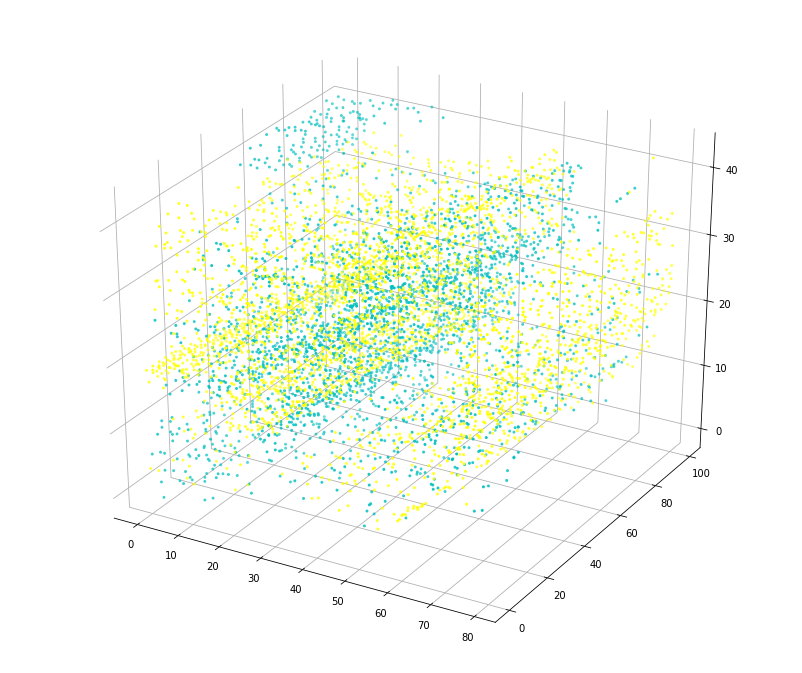

In [7]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
i=5
# for i in range(100):
smp=tr_car[0,i]
img=np.hstack((smp['x'],smp['y'],smp['p'],smp['ts']))
# img=img[(img[:,3]<50000),:]
scale=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
#        show_img(img)
#     if(img.shape[0]>5000):

# scale=np.array([[1,0,0,0],[0,3,0,0],[0,0,1,0],[0,0,0,1]])
fig=plt.figure(frameon=False,figsize=(14,12))

show_img(img,fig)
plt.savefig("car3d.png")
        

In [8]:
ntr=np.sum(trn_bgr==True)+np.sum(trn_car==True)
nts=np.sum(tsn_bgr==True)+np.sum(tsn_car==True)
train=np.empty((ntr,tot_cell*rho*rho))
test=np.empty((nts,tot_cell*rho*rho))
y=np.empty((ntr))
y_test=np.empty((nts))
y[:np.sum(trn_bgr==True)]=0
y[np.sum(trn_bgr==True):]=1
y_test[:np.sum(tsn_bgr==True)]=0
y_test[np.sum(tsn_bgr==True):]=1

NameError: name 'trn_bgr' is not defined

In [18]:
class Events(object):
    """
    Temporal Difference events.
    data: a NumPy Record Array with the following named fields
        x: pixel x coordinate, unsigned 16bit int
        y: pixel y coordinate, unsigned 16bit int
        p: polarity value, boolean. False=off, True=on
        ts: timestamp in microseconds, unsigned 64bit int
    width: The width of the frame. Default = 304.
    height: The height of the frame. Default = 240.
    """
    def __init__(self, num_events, width=304, height=240):
        """num_spikes: number of events this instance will initially contain"""
        self.data = np.rec.array(None, dtype=[('x', np.uint16), ('y', np.uint16), ('p', np.bool_), ('ts', np.uint64)], shape=(num_events))
        self.width = width
        self.height = height

    def show_em(self):
        """Displays the EM events (grayscale ATIS events)"""
        frame_length = 24e3
        t_max = self.data.ts[-1]
        frame_start = self.data[0].ts
        frame_end = self.data[0].ts + frame_length
        max_val = 1.16e5
        min_val = 1.74e3
        val_range = max_val - min_val

        thr = np.rec.array(None, dtype=[('valid', np.bool_), ('low', np.uint64), ('high', np.uint64)], shape=(self.height, self.width))
        thr.valid.fill(False)
        thr.low.fill(frame_start)
        thr.high.fill(0)

    def show_em_frame(frame_data):
        """Prepare and show a single frame of em data to be shown"""
        for datum in np.nditer(frame_data):
            ts_val = datum['ts'].item(0)
            thr_data = thr[datum['y'].item(0), datum['x'].item(0)]

            if datum['p'].item(0) == 0:
                thr_data.valid = 1
                thr_data.low = ts_val
            elif thr_data.valid == 1:
                thr_data.valid = 0
                thr_data.high = ts_val - thr_data.low

        img = 255 * (1 - (thr.high - min_val) / (val_range))
        #thr_h = cv2.adaptiveThreshold(thr_h, 255,
        #cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 0)
        img = np.piecewise(img, [img <= 0, (img > 0) & (img < 255), img >= 255], [0, lambda x: x, 255])
        img = img.astype('uint8')
        cv2.imshow('img', img)
        cv2.waitKey(1)

        while frame_start < t_max:
            #with timer.Timer() as em_playback_timer:
            frame_data = self.data[(self.data.ts >= frame_start) & (self.data.ts < frame_end)]
            show_em_frame(frame_data)
            frame_start = frame_end + 1
            frame_end += frame_length + 1
            #print 'showing em frame took %s seconds' %em_playback_timer.secs

        cv2.destroyAllWindows()
        return

    def show_td(self,video ,wait_delay=1):
        """Displays the TD events (change detection ATIS or DVS events)
        waitDelay: milliseconds
        """
        frame_length = 24e3
#         print("here")
#         pdb.set_trace()
        t_max = self.data.ts[-1]
        frame_start = self.data[0].ts
        frame_end = self.data[0].ts + frame_length
        td_img = np.ones((self.height, self.width), dtype=np.uint8)
#         cv2.namedWindow('image')
#         cv2.resizeWindow('image', 600,600)
        while frame_start < t_max:
            frame_data = self.data[(self.data.ts >= frame_start) & (self.data.ts < frame_end)]
            
            if frame_data.size > 0:
                td_img.fill(255)

                #with timer.Timer() as em_playback_timer:
                for datum in np.nditer(frame_data):
                    td_img[datum['y'].item(0), datum['x'].item(0)] = datum['p'].item(0)
                #print 'prepare td frame by iterating events took %s seconds'
                #%em_playback_timer.secs

#                 td_img = np.piecewise(td_img, [td_img == 0, td_img == 1, td_img == 255], [0, 0, 0])
                imS = cv2.resize(td_img, (500, 500)) 
#                 imS.imsave("car.png")
                video.write(cv2.cvtColor(imS,cv2.COLOR_GRAY2BGR))
#                 cv2.imshow('image', imS)
                cv2.waitKey(wait_delay)

            frame_start = frame_end + 1
            frame_end = frame_end + frame_length + 1

#         cv2.destroyAllWindows()
        return

    def filter_td(self, us_time):
        """Generate a filtered set of event data.
        Does not modify instance data
        Uses a background activity filter on the events, such that only events which are
        correlated with a neighbouring event within 'us_time' microseconds will be allowed
        through the filter.
        us_time: microseconds
        """
        max_x = self.width - 1
        max_y = self.height - 1
        t0 = np.ones((self.width, self.height)) - us_time - 1
        x_prev = 0
        y_prev = 0
        p_prev = 0
        valid_indices = np.ones(len(self.data), np.bool_)
        i = 0

        with timer.Timer() as ref_timer:
            for datum in np.nditer(self.data):
                datum_ts = datum['ts'].item(0)
                datum_x = datum['x'].item(0)
                datum_y = datum['y'].item(0)
                datum_p = datum['p'].item(0)
                if x_prev != datum_x | y_prev != datum_y | p_prev != datum_p:
                    t0[datum_x, datum_y] = -us_time
                    min_x_sub = max(0, datum_x - 1)
                    max_x_sub = min(max_x, datum_x + 1)
                    min_y_sub = max(0, datum_y - 1)
                    max_y_sub = min(max_y, datum_y + 1)

                    t0_temp = t0[min_x_sub:(max_x_sub + 1), min_y_sub:(max_y_sub + 1)]

                    if min(datum_ts - t0_temp.reshape(-1, 1)) > us_time:
                        valid_indices[i] = 0

                t0[datum_x, datum_y] = datum_ts
                x_prev = datum_x
                y_prev = datum_y
                p_prev = datum_p
                i = i + 1
        print ('filtering took %s seconds' % ref_timer.secs)
        return self.data[valid_indices.astype('bool')]

    def sort_order(self):
        """Generate data sorted by ascending ts
        Does not modify instance data
        Will look through the struct events, and sort all events by the field 'ts'.
        In other words, it will ensure events_out.ts is monotonically increasing,
        which is useful when combining events from multiple recordings.
        """
        #chose mergesort because it is a stable sort, at the expense of more
        #memory usage
        events_out = np.sort(self.data, order='ts', kind='mergesort')
        return events_out

    def extract_roi(self, top_left, size, is_normalize=False):
        """Extract Region of Interest
        Does not modify instance data
        Generates a set of td_events which fall into a rectangular region of interest with
        top left corner at 'top_left' and size 'size'
        top_left: [x: int, y: int]
        size: [width, height]
        is_normalize: bool. If True, x and y values will be normalized to the cropped region
        """
        min_x = top_left[0]
        min_y = top_left[1]
        max_x = size[0] + min_x
        max_y = size[1] + min_y
        extracted_data = self.data[(self.data.x >= min_x) & (self.data.x < max_x) & (self.data.y >= min_y) & (self.data.y < max_y)]

        if is_normalize:
            self.width = size[0]
            self.height = size[1]
            extracted_data = np.copy(extracted_data)
            extracted_data = extracted_data.view(np.recarray)
            extracted_data.x -= min_x
            extracted_data.y -= min_y

        return extracted_data

    def apply_refraction(self, us_time):
        """Implements a refractory period for each pixel.
        Does not modify instance data
        In other words, if an event occurs within 'us_time' microseconds of
        a previous event at the same pixel, then the second event is removed
        us_time: time in microseconds
        """
        t0 = np.ones((self.width, self.height)) - us_time - 1
        valid_indices = np.ones(len(self.data), np.bool_)

        #with timer.Timer() as ref_timer:
        i = 0
        for datum in np.nditer(self.data):
            datum_ts = datum['ts'].item(0)
            datum_x = datum['x'].item(0)
            datum_y = datum['y'].item(0)
            if datum_ts - t0[datum_x, datum_y] < us_time:
                valid_indices[i] = 0
            else:
                t0[datum_x, datum_y] = datum_ts

            i += 1
        #print 'Refraction took %s seconds' % ref_timer.secs

        return self.data[valid_indices.astype('bool')]

    def write_j_aer(self, filename):
        """
        writes the td events in 'td_events' to a file specified by 'filename'
        which is compatible with the jAER framework.
        To view these events in jAER, make sure to select the DAVIS640 sensor.
        """
        import time
        y = 479 - self.data.y
        #y = td_events.y
        y_shift = 22 + 32

        x = 639 - self.data.x
        #x = td_events.x
        x_shift = 12 + 32

        p = self.data.p + 1
        p_shift = 11 + 32

        ts_shift = 0

        y_final = y.astype(dtype=np.uint64) << y_shift
        x_final = x.astype(dtype=np.uint64) << x_shift
        p_final = p.astype(dtype=np.uint64) << p_shift
        ts_final = self.data.ts.astype(dtype=np.uint64) << ts_shift
        vector_all = np.array(y_final + x_final + p_final + ts_final, dtype=np.uint64)
        aedat_file = open(filename, 'wb')

        version = '2.0'
        aedat_file.write('#!AER-DAT' + version + '\r\n')
        aedat_file.write('# This is a raw AE data file - do not edit\r\n')
        aedat_file.write \
            ('# Data format is int32 address, int32 timestamp (8 bytes total), repeated for each event\r\n')
        aedat_file.write('# Timestamps tick is 1 us\r\n')
        aedat_file.write('# created ' + time.strftime("%d/%m/%Y") \
            + ' ' + time.strftime("%H:%M:%S") \
            + ' by the Python function "write2jAER"\r\n')
        aedat_file.write \
            ('# This function fakes the format of DAVIS640 to allow for the full ATIS address space to be used (304x240)\r\n')
        ##aedat_file.write(vector_all.astype(dtype='>u8').tostring())
        to_write = bytearray(vector_all[::-1])
        to_write.reverse()
        aedat_file.write(to_write)
        #aedat_file.write(vector_all)
        #vector_all.tofile(aedat_file)
        aedat_file.close()

In [22]:
import cv2
import os
video_name = 'car_examples.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
# fourcc = cv2.VideoWriter_fourcc('M','J','P','G')

video = cv2.VideoWriter(video_name, fourcc, 60, (500,500))
print(video.isOpened())
for i in range(500):
    
    event=Events(tr_car[0,i]['x'].shape[0],120,100)
    smp=tr_car[0,i]
    event.data.ts=smp['ts'][:,0]
    event.data.x=smp['x'][:,0]
    event.data.y=smp['y'][:,0]
    event.data.p=smp['p'][:,0]
    event.show_td(video,1000000)
cv2.destroyAllWindows()
video.release()

True


In [19]:
import cv2
import os
video_name = 'car.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
# fourcc = cv2.VideoWriter_fourcc('M','J','P','G')

video = cv2.VideoWriter(video_name, fourcc, 60, (500,500))
print(video.isOpened())
i=200
event=Events(tr_car[0,i]['x'].shape[0],120,100)
smp=tr_car[0,i]
event.data.ts=smp['ts'][:,0]
event.data.x=smp['x'][:,0]
event.data.y=smp['y'][:,0]
event.data.p=smp['p'][:,0]
event.show_td(video,1000000)
cv2.destroyAllWindows()
video.release()

True


In [10]:
# y.shape

In [13]:
def gethist2(smp):
    hist=np.zeros((tot_cell,rho,rho))
    cnt=np.zeros((tot_cell))
    events=np.hstack((smp['x'],smp['y'],smp['p'],smp['ts']))
    time=np.zeros((tot_cell,2,2))
    mem=[[[],[]] for i in range(tot_cell)]
    for m in range(events.shape[0]):
        event=events[m,:]
        cell_id=(event[0]//K)*n_cell[1]+(event[1]//K)
        t=event[3]
        tmsurf=np.zeros((rho,rho))
        ind= 1 if event[2]>0 else 0
        for e in mem[cell_id][ind]:
            if(np.abs(event[0]-e[0])<=rho//2 and np.abs(event[1]-e[1])<=rho//2):
                tmsurf[event[0]-e[0]+rho//2,event[1]-e[1]+rho//2]+=np.exp(-(t-e[3])/tau)
        hist[cell_id,:,:]+=tmsurf
        cnt[cell_id]+=1
        if(len(mem[cell_id][ind])) :
            time[cell_id,ind,1]=t
        else :
            time[cell_id,ind,0]=t
        mem[cell_id][ind].appendleft(event)
        while(time[cell_id,ind,1]-time[cell_id,ind,0]>ti):
            mem[cell_id][ind].pop()  
            time[cell_id,ind,0]=mem[cell_id][ind][-1][3]
    for i in range(tot_cell):
        if(cnt[i]):
            hist[i,:,:]/=cnt[i]
    return hist.ravel()  

In [47]:
import numpy.ma as ma
def gethist3(smp):
    max_mem=0
    hist=np.zeros((tot_cell,rho,rho))
    cnt=np.zeros((tot_cell))
    cnt_mem=np.zeros((tot_cell,2))
#     pdb.set_trace()
    mem=[[[],[]] for i in range(tot_cell)]
    events=np.hstack((smp['x'],smp['y'],smp['p'],smp['ts']))
    events[:,2]+=1
    events[:,2]=events[:,2]/2
#     print(events[:,2])
    cell_id=(events[:,0]//K)*n_cell[1]+(events[:,1]//K)
    events=events[cell_id<15,:]
#     return cell_id.shape[0]
#     print(cell_id,ma.masked_array(cell_id, mask=events[:,2]))

#     for i in range(tot_cell):
#         cnt[i]=np.sum(cell_id==i)
#         cnt_mem[i,0]=np.sum(ma.masked_array(cell_id, mask=events[:,2])==i)
#         cnt_mem[i,1]=cnt[i]-cnt_mem[i,0]
# #         print(cnt[i],cnt_mem[i,:])
    for m in range(events.shape[0]):
        event=events[m,:]
#         tmsurf=np.zeros((rho,rho))
#         print(np.asarray(mem[cell_id[m]][event[2]]).shape)
        max_mem+=np.asarray(mem[cell_id[m]][event[2]]).shape[0]
        
#         if(e.shape[0]):
#             a=np.abs(event[0]-e[:,0])<=rho//2 
#             b=np.abs(event[1]-e[:,1])<=rho//2
#             mask=np.logical_and(a, b)
#             e=e[mask,:]
#             for i in range(e.shape[0]):
#                 tmsurf[e[i,0]-event[0]+rho//2,e[i,1]-event[1]+rho//2]+=np.exp(-(event[3]-e[i,3])/tau)
#             hist[cell_id[m],:,:]+=tmsurf
# #             show_surface(hist)
        mem[cell_id[m]][event[2]].append(event)
#     for i in range(tot_cell):
#         if(cnt[i]):
#             hist[i,:,:]/=cnt[i]
#     return hist
#     print(cnt_mem)
    return max_mem/events.shape[0]

In [48]:
# for i in range(5):
#     smp=tr_car[0,i]
#     gethist3(tr_car[0,i])
#     events=np.hstack((smp['x'],smp['y'],smp['p'],smp['ts']))    
#     events[:,2]+=1
#     events[:,2]=events[:,2]/2 
#     events.tofile('files/input'+str(i)+'.bin')

In [50]:
sum=0
for i in range(tr_car.shape[1]):
    sum+=gethist3(tr_car[0,i])
#     print(sum)
print(sum/tr_car.shape[1])

19.308924887277566


In [32]:
# Parallel Processing on CPU
start_time = time.time()
with Pool(12) as p:
    tr_car_hist=p.map(gethist3,tr_car[0,:])
# print('done')
# with Pool(12) as p:
#     ts_car_hist=p.map(gethist3,ts_car[0,:])
# print('done')
# with Pool(12) as p:
#     tr_bgr_hist=p.map(gethist3,tr_bgr[0,:])
# print('done')
# with Pool(12) as p:
#     ts_bgr_hist=p.map(gethist3,ts_bgr[0,:])
# print('done')
print(time.time()-start_time)

11.349477052688599


In [33]:
np.mean(tr_car_hist)

161.61133501259445

In [34]:
print(tr_car_hist)

[211.0, 168.0, 218.0, 246.0, 200.0, 198.0, 159.0, 175.0, 146.0, 137.0, 116.0, 98.0, 86.0, 94.0, 135.0, 130.0, 95.0, 119.0, 102.0, 293.0, 380.0, 314.0, 305.0, 438.0, 213.0, 184.0, 170.0, 164.0, 136.0, 144.0, 156.0, 114.0, 349.0, 371.0, 453.0, 322.0, 281.0, 235.0, 252.0, 195.0, 165.0, 214.0, 170.0, 158.0, 230.0, 172.0, 119.0, 126.0, 259.0, 362.0, 331.0, 271.0, 233.0, 208.0, 430.0, 291.0, 307.0, 512.0, 451.0, 353.0, 299.0, 230.0, 211.0, 194.0, 150.0, 139.0, 119.0, 108.0, 125.0, 82.0, 82.0, 530.0, 378.0, 530.0, 505.0, 432.0, 361.0, 309.0, 243.0, 219.0, 160.0, 168.0, 154.0, 154.0, 147.0, 248.0, 193.0, 97.0, 149.0, 114.0, 85.0, 241.0, 254.0, 213.0, 192.0, 224.0, 196.0, 179.0, 161.0, 110.0, 91.0, 95.0, 222.0, 281.0, 372.0, 374.0, 275.0, 314.0, 419.0, 382.0, 336.0, 249.0, 277.0, 141.0, 132.0, 412.0, 408.0, 607.0, 520.0, 346.0, 270.0, 316.0, 243.0, 193.0, 127.0, 107.0, 108.0, 385.0, 305.0, 221.0, 239.0, 359.0, 289.0, 271.0, 234.0, 220.0, 164.0, 204.0, 126.0, 132.0, 144.0, 120.0, 416.0, 123.0, 3

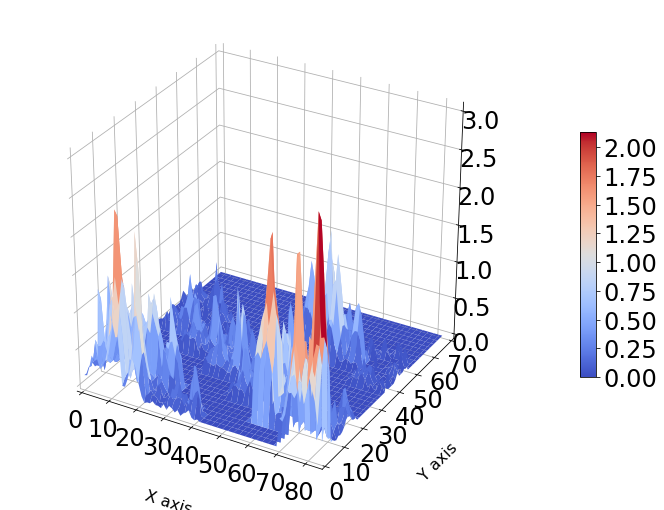

In [24]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
scale=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
i=5
# for i in range(10):
fig=plt.figure(figsize=(12,9))
hist=gethist3(tr_bgr[0,i])
ans=np.zeros((70,84))
for j in range(tot_cell):
    m=j%12
    n=j//12
#         print(m,n)
    ans[7*n:7*(n+1),7*m:7*(m+1)]=hist[j,:,:]
X=np.arange(0,84)
Y=np.arange(0,70)
X, Y = np.meshgrid(X, Y)
# fig = plt.figure()
ax = fig.gca(projection='3d')
#scale=np.array([[1,0,0,0],[0,1,0,0],[0,0,0.5,0],[0,0,0,1]])
# ax.grid('False')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
Axes3D.get_proj=get_proj_scale
surf=ax.plot_surface(X,Y,ans,cmap=cm.coolwarm,linewidth=0)
ax.set_xlabel('X axis',fontsize=16)
ax.set_ylabel('Y axis',fontsize=16)
ax.set_xlim(0, 84)
ax.set_ylim(0, 70)
ax.xaxis._axinfo['label']['space_factor'] = 50
fig.colorbar(surf, shrink=0.5, aspect=15, pad=0.1, orientation='vertical')
#     ax2= fig.add_subplot(442)
#     ax2.imshow(ans,cmap=cm.coolwarm)
#     smp=tr_car[0,i]
#     img=np.hstack((smp['x'],smp['y'],smp['p'],smp['ts']))
#     show_img(img,fig)
# plt.savefig('hats3d.png')
# plt.show()
ax.yaxis.labelpad=30
ax.xaxis.labelpad=30
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)
plt.savefig('hats3d.png',orientation='landscape',facecolor='white',bbox_inches = 'tight')

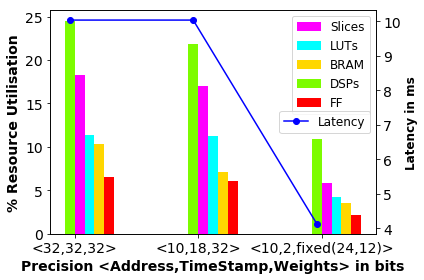

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple


n_groups = 3

# means_men = (20, 35, 30, 35, 27)
slices=(18.31,17.02,5.83)
lut=(11.33,11.20,4.21)
bram=(10.36,7.14,3.57)
dsp=(24.54,21.81,10.90)
ff=(6.56,6.08,2.22)
fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.08

# opacity = 0.4
# error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index+bar_width, slices, bar_width, color='magenta', error_kw=error_config,label='Slices')
rects2 = ax.bar(index + 2*bar_width, lut , bar_width, color='aqua', error_kw=error_config, label='LUTs')
rects4 = ax.bar(index + 3*bar_width, bram , bar_width, color='gold', error_kw=error_config, label='BRAM')
rects5 = ax.bar(index + 0*bar_width, dsp , bar_width, color='lawngreen', error_kw=error_config, label='DSPs')
rects3 = ax.bar(index + 4*bar_width, ff , bar_width, color='red', error_kw=error_config, label='FF')
ax.set_xlabel('Precision <Address,TimeStamp,Weights> in bits',fontsize=14,fontweight='bold')
ax.set_ylabel('% Resource Utilisation',fontsize=14,fontweight='bold')
# ax.set_title('')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('<32,32,32>', '<10,18,32>', '<10,2,fixed(24,12)>'))
ax.legend(fontsize=12)
ax2 = ax.twinx()   # mirror them
ax2.plot([10.04,10.04,4.14],marker='o',color='blue',label='Latency')
ax2.set_ylabel('Latency in ms',fontsize=12,fontweight='bold')
ax2.legend(loc='center right',fontsize=12)
fig.tight_layout()
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)
plt.savefig('resource.png', bbox_inches = 'tight')
plt.show()


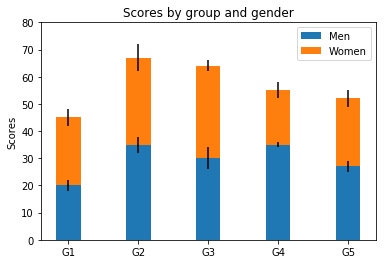

In [36]:
import numpy as np
import matplotlib.pyplot as plt


N = 5
menMeans = (20, 35, 30, 35, 27)
womenMeans = (25, 32, 34, 20, 25)
menStd = (2, 3, 4, 1, 2)
womenStd = (3, 5, 2, 3, 3)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, menMeans, width, yerr=menStd)
p2 = plt.bar(ind, womenMeans, width,
             bottom=menMeans, yerr=womenStd)

plt.ylabel('Scores')
plt.title('Scores by group and gender')
plt.xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()

In [106]:
test[:np.sum(tsn_bgr==True),:]=np.asarray(ts_bgr_hist) 
test[np.sum(tsn_bgr==True):,:]=np.asarray(ts_car_hist) 
train[:np.sum(trn_bgr==True),:]=np.asarray(tr_bgr_hist)       
train[np.sum(trn_bgr==True):,:]=np.asarray(tr_car_hist)     


In [2]:
from sklearn.svm import LinearSVC
from sklearn.externals import joblib


In [112]:
clf = LinearSVC(C=0.01)
print ("Training a Linear SVM Classifier")
clf.fit(train, y)
# joblib.dump(clf, 'svm87.5.model')
tr_acc=np.sum(clf.predict(train)==y)
acc=np.sum(clf.predict(test)==y_test)
print(acc/y_test.shape[0],tr_acc/y.shape[0])
    

Training a Linear SVM Classifier
0.8711513884047868 0.9405394890416289


In [19]:
clf = joblib.load('svm86.8.model') 
coeff=clf.coef_
b=clf.intercept_


In [103]:
coeff.shape

(1, 5880)

In [20]:
print(coeff[0,:735])

[-2.06352875e-02 -1.15818064e+00  4.31725241e-01 -1.19107394e-01
  3.50519680e-02  4.87258904e-01  2.17058890e-02 -1.33315081e-01
 -2.10070678e-01  3.64833273e-01 -7.80356465e-01 -1.38639881e-02
 -2.05106389e-01  1.97231048e-02  1.11274277e-01  2.49579896e-01
 -1.68757593e+00  1.41651766e+00  5.89887373e-01 -3.37056535e-01
 -3.95164748e-01 -3.46986890e-01  3.32498744e-01  1.41626835e+00
  2.48518098e-01  8.25040721e-01 -4.12057623e-01  2.14601866e-01
 -7.00741458e-02  3.85636450e-01  4.69969104e-01  1.98787211e-01
 -8.04459848e-01  3.30705801e-01 -8.56278989e-01  6.15395203e-02
  3.74045907e-01 -1.11330035e+00 -4.93453470e-01 -5.75661133e-01
  3.81626226e-01  7.06135328e-01  9.19978475e-01  7.40159650e-01
 -7.08570913e-01 -3.71516947e-01 -3.80740168e-01  1.91950990e-01
  7.53439453e-01  3.65743483e-01 -6.40659083e-02 -8.11757358e-01
 -8.50734056e-01 -1.25105665e-01  1.15065990e+00  7.37927822e-01
  3.64723618e-01 -2.09821402e-01 -1.19371808e+00  2.97068444e-01
 -1.09931239e+00  2.45808

In [17]:
for i in range(8):
    coeff[0,735*i:735*(i+1)]=coeff[0,:735]

In [29]:
def predict(features,w):
        dot_result = np.sign(np.dot(features,w.T)+b)
        return dot_result.astype(int)


In [69]:
print(b)

[-1.59258933]


In [24]:
tr_car_hist=np.array(tr_car_hist)
print(tr_car_hist.shape)
result=np.dot(tr_car_hist,coeff.T)
np.savetxt("result.csv",result)

(100, 5880)


In [15]:
w=np.empty((coeff.shape))
new_test=np.empty((test.shape))
for resolution in [4,6,8,10,12]:
        family = FixedPoint.FXfamily(resolution)
        for i in range(w.shape[1]):
            w[0,i]=family(coeff[0,i])
        for i in range(test.shape[0]):
            for j in range(test.shape[1]):
                new_test[i,j]=family(test[i,j])
        predictions=(predict(new_test,w)+1)//2
#         print(predictions[0,:]==y_test)
        acc_new=np.sum(predictions[:,0]==y_test)
        print(acc_new/y_test.shape[0])


In [5]:
w=np.empty((coeff.shape))
for resolution in [4,6,8,10,12]:
        family = FixedPoint.FXfamily(resolution)
        print(family.fraction_bits,family.integer_bits)
        for i in range(w.shape[1]):
            w[0,i]=family(coeff[0,i])

4 None
6 None
8 None
10 None
12 None


In [6]:
# %%cython -a
# cimport numpy as np
# cimport cython
# @cython.boundscheck(False) # turn off bounds-checking for entire function
# @cython.wraparound(False)  # turn off negative index wrapping for entire function
# def getcython(smp):
#     hist=np.zeros((tot_cell,rho,rho))
#     cnt=np.zeros((tot_cell))
#     mem=[[[],[]] for i in range(tot_cell)]
#     events=np.hstack((smp['x'],smp['y'],smp['p'],smp['ts']))
#     events[:,2]+=1
#     events[:,2]=events[:,2]/2
#     cell_id=(events[:,0]//K)*n_cell[1]+(events[:,1]//K)
#     for i in range(tot_cell):
#         cnt[i]=np.sum(cell_id==i)
#     for m in range(events.shape[0]):
#         event=events[m,:]
#         tmsurf=np.zeros((rho,rho))
#         e=np.array(mem[cell_id[m]][event[2]])
#         if(e.shape[0]):
#             a=np.abs(event[0]-e[:,0])<=rho//2 
#             b=np.abs(event[1]-e[:,1])<=rho//2
#             mask=np.logical_and(a, b)
# #             e=e[mask,:]
#             t_hat=1-(event[3])/tau
#             for i in range(rho):
#                 for j in range(rho):
#                     a=e[:,0]-event[0]+rho//2==i
#                     b=e[:,1]-event[1]+rho//2==j
#                     mask=np.logical_and(a, b)
#                     tmsurf[i,j]=np.sum(e[mask,3])/tau+t_hat
# #             tmsurf[e[mask,0]+rho//2-event[0],e[mask,1]-event[1]+rho//2]=e[mask,3]/tau+t_hat
#             hist[cell_id[m],:,:]+=tmsurf
#             cnt[cell_id[m]]+=1
#         mem[cell_id[m]][event[2]].append(event)
#     for i in range(tot_cell):
#         if(cnt[i]):
#             hist[i,:,:]/=cnt[i]
#     return hist
